In [ ]:
import random
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Adjust Model Structure Depends on the Data
num_classes = 47 # label 0~9: total 10 classes
in_channel = 1 # black and white images: 1 channel (RGB: 3 channels)

# Hyper-parameters
batch_size = 100
max_pool_kernel = 2
learning_rate = 0.0001
num_epochs = 3

In [ ]:
train_data = torchvision.datasets.EMNIST(root='./EMNST',split='bymerge', train=True, download=True, transform=transforms.ToTensor()) 
test_data = torchvision.datasets.EMNIST(root='./EMNST',split='bymerge', train=False, download=True, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data,
                                           batch_size=batch_size,
                                           shuffle=True)

Extracting ./EMNST/EMNIST/raw/emnist.zip to ./EMNST/EMNIST/raw
Processing byclass


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Processing bymerge
Processing balanced
Processing letters
Processing digits
Processing mnist
Done!


In [ ]:
import torch.nn.functional as F
import torchsummary as summary #optional, to see model's summary
class ConvNet(nn.Module):
  def __init__(self, num_classes=47):
    super(ConvNet, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(in_channel, 10, 3, stride=1,padding=1),
        nn.BatchNorm2d(10),
        nn.ReLU(),
        nn.MaxPool2d(max_pool_kernel)
    )
    self.layer2 = nn.Sequential(
        nn.Conv2d(10, 100, 3 , stride=1, padding=1),
        nn.BatchNorm2d(100),
        nn.ReLU(),
        nn.MaxPool2d(max_pool_kernel)
    )
    self.fc1 = nn.Linear(7*7*100, 512)
    self.fc2 = nn.Linear(512, 128)
    self.fc3 = nn.Linear(128, 64)
    self.fc4 = nn.Linear(64, num_classes)

  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = x.reshape(x.size(0),-1)
    x=F.dropout(x)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = torch.sigmoid(self.fc4(x))
    return x

In [ ]:
model = ConvNet(num_classes).to(device)

In [ ]:
# cf) see network form
print(model)

# cf) check the number of parameters
print('{:=^60}'.format("="))
print('{:^60}'.format("model summary"))
print('{:=^60}'.format("="))
for param_tensor in model.state_dict():
  print('%-30s'%param_tensor, '{:^30}'.format(str(model.state_dict()[param_tensor].size())))
print('{:=^60}'.format("="))

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(10, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=4900, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=47, bias=True)
)
                       model summary                        
layer1.0.weight                  torch.Size([10, 1, 3, 3])   
layer1.0.bias                      

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
total_step = len(train_loader)
loss_list = []

# Train
for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    # Assign Tensors to Configured Device
    images = images.to(device)
    labels = labels.to(device).long()

    # Forward Propagation
    outputs = model(images)
    
    # Get Loss, Compute Gradient, Update Parameters
    loss = criterion(outputs,labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Append loss to plot graph
    loss_list.append(loss)

    # Print Loss for Tracking Training

    if (i+1) % 1000 == 0:
      print("Epoch [{}/{}], Step[{}/{}], Loss:{:.4f}".format(epoch+1, num_epochs, i+1, total_step, loss.item()))

  if epoch+1 == num_epochs:
    torch.save(model.state_dict(), '20151600_model2.pth')
  else:
    torch.save(model.state_dict(), 'model-{:02d}_epochs.pth'.format(epoch+1))

Epoch [1/3], Step[1000/6980], Loss:3.0725
Epoch [1/3], Step[2000/6980], Loss:3.0368
Epoch [1/3], Step[3000/6980], Loss:3.0065
Epoch [1/3], Step[4000/6980], Loss:3.0003
Epoch [1/3], Step[5000/6980], Loss:2.9748
Epoch [1/3], Step[6000/6980], Loss:2.9888
Epoch [2/3], Step[1000/6980], Loss:2.9968
Epoch [2/3], Step[2000/6980], Loss:2.9754
Epoch [2/3], Step[3000/6980], Loss:3.0576
Epoch [2/3], Step[4000/6980], Loss:3.0118
Epoch [2/3], Step[5000/6980], Loss:2.9850
Epoch [2/3], Step[6000/6980], Loss:3.0019
Epoch [3/3], Step[1000/6980], Loss:2.9888
Epoch [3/3], Step[2000/6980], Loss:2.9931
Epoch [3/3], Step[3000/6980], Loss:2.9867
Epoch [3/3], Step[4000/6980], Loss:2.9762
Epoch [3/3], Step[5000/6980], Loss:2.9456
Epoch [3/3], Step[6000/6980], Loss:2.9560


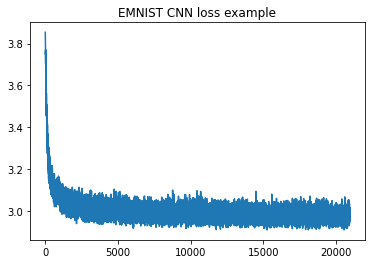

In [ ]:
import matplotlib.pyplot as plt
plt.plot(loss_list)
plt.title("EMNIST CNN loss example")
plt.show()

In [ ]:
test_model = ConvNet(num_classes)
test_model.load_state_dict(torch.load("20151600_model2.pth"))

with torch.no_grad(): # auto_grad off
  correct = 0
  total = 0
  for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  print('Accuracy of the network on the {} test images {}%'.format(len(test_loader)*batch_size, 100*correct/total))

Accuracy of the network on the 116400 test images 81.50494743086062%
